In [1]:
import pickle

import pandas as pd
from yellowbrick.model_selection import LearningCurve
from sklearn.metrics import accuracy_score
import json
import matplotlib.pyplot as plt
from sklearnex import patch_sklearn
import numpy as np

patch_sklearn()
from copy import deepcopy
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv  # noqa
# now you can import normally from model_selection
from sklearn.model_selection import train_test_split
from drowsiness_detection.data import (get_feature_data, preprocess_feature_data,
                                       session_type_mapping)
from drowsiness_detection import config
from sklearn.model_selection import StratifiedKFold

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
WINDOW_SIZE = 60
config.set_paths(30, WINDOW_SIZE)

In [7]:
# load hyperparameter results
with open("../logs/21/search_result.pkl", "rb") as fp:
    search_result = pickle.load(fp)

cv_results = pd.DataFrame.from_dict(search_result.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__max_features,param_classifier__n_estimators,params,split0_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,505.45341,142.967336,1.003339,0.352367,entropy,35,sqrt,512,"{'classifier__criterion': 'entropy', 'classifi...",0.740121,...,0.99996,0.99996,0.99996,1.0,0.99996,0.99996,0.99996,0.99996,0.999964,0.000012


In [8]:
best_params = search_result.best_params_
print(best_params)
best_model_results = cv_results.where(
    (cv_results["param_classifier__criterion"] == best_params["classifier__criterion"]) & (
            cv_results["param_classifier__max_depth"] == best_params["classifier__max_depth"]) & (
            cv_results[
                "param_classifier__max_features"] == best_params[
                "classifier__max_features"])).dropna()
best_model_results

{'classifier__criterion': 'entropy', 'classifier__max_depth': 35, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 512}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__max_features,param_classifier__n_estimators,params,split0_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,505.45341,142.967336,1.003339,0.352367,entropy,35,sqrt,512,"{'classifier__criterion': 'entropy', 'classifi...",0.740121,...,0.99996,0.99996,0.99996,1.0,0.99996,0.99996,0.99996,0.99996,0.999964,0.000012


In [9]:
best_model_results["params"] = best_model_results["params"].apply(lambda x: json.dumps(x))
try:
    best_model_results = best_model_results.drop_duplicates(subset=("params", "iter"))
except KeyError:
    best_model_results = best_model_results.drop_duplicates(subset=("params"))

best_model_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__max_features,param_classifier__n_estimators,params,split0_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,505.45341,142.967336,1.003339,0.352367,entropy,35,sqrt,512,"{""classifier__criterion"": ""entropy"", ""classifi...",0.740121,...,0.99996,0.99996,0.99996,1.0,0.99996,0.99996,0.99996,0.99996,0.999964,0.000012


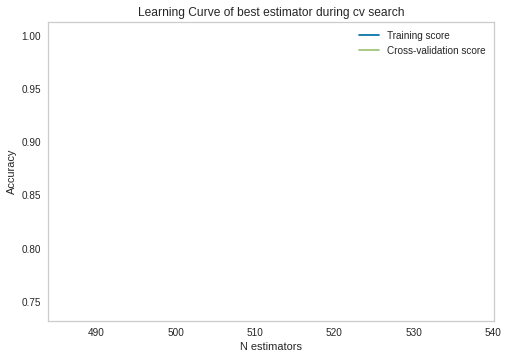

In [10]:
def plot_learning_curve(search_cv_results: pd.DataFrame, ax=None, show_legend=True,
                        title: str = "Learning Curve"):
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_title(label=title)
    ax.set_xlabel("N estimators")
    ax.set_ylabel("Accuracy")
    train_sizes = search_cv_results["param_classifier__n_estimators"].astype(int)
    train_scores_mean = search_cv_results["mean_train_score"]
    test_scores_mean = search_cv_results["mean_test_score"]
    plt.grid()

    # train_scores_std = search_cv_results["std_train_score"]
    # test_scores_std = search_cv_results["std_test_score"]
    # plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
    #                  train_scores_mean + train_scores_std, alpha=0.1,
    #                  color="r")
    # plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
    #                  test_scores_mean + test_scores_std, alpha=0.1, color="g")

    ax.plot(train_sizes, train_scores_mean, '-',  # color="r",
            label="Training score")
    ax.plot(train_sizes, test_scores_mean, '-',  # color="g",
            label="Cross-validation score")
    if show_legend:
        plt.legend(loc="best")


plot_learning_curve(search_cv_results=best_model_results,
                    title="Learning Curve of best estimator during cv search")
plt.show()

In [11]:
best_estimator = search_result.estimator.set_params(**best_params)
n_splits = 10
seed = 123
test_size = .2
num_targets = 2
exclude_by = 'a'


In [12]:
data = get_feature_data(data_path=config.PATHS.WINDOW_FEATURES)
X, y = preprocess_feature_data(feature_data=data,
                               exclude_sess_type=session_type_mapping[exclude_by],
                               num_targets=num_targets)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                    random_state=seed)

In [14]:
cv = StratifiedKFold(n_splits=n_splits, random_state=seed,
                     shuffle=True)
visualizer = LearningCurve(estimator=best_estimator, scoring="accuracy", n_jobs=-2)

In [15]:
num_samples = 100
visualizer.fit(X_train[:num_samples], y_train[:num_samples])
visualizer.show()  # was working for small number of samples, check again

# use yellowbrick to retrain random forest with exact same conditions as in cv search and plot learning curve

<AxesSubplot:title={'center':'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

plot accuracy while fitting more trees

In [16]:
scaler = best_estimator.named_steps['scaler']
num_samples = -1

X_train_scaled = scaler.fit_transform(X_train, y_train)[:num_samples]
X_test_scaled = scaler.transform(X_test)[:num_samples]



In [17]:
warm_start_params = best_params.copy()
warm_start_params['classifier__n_estimators'] = 1
warm_start_params["classifier__warm_start"] = True
warm_start_params['classifier__n_jobs'] = -2
warm_start_params["classifier__max_depth"] = 80

print(warm_start_params)
best_estimator = search_result.estimator.set_params(**warm_start_params)


{'classifier__criterion': 'entropy', 'classifier__max_depth': 80, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 1, 'classifier__warm_start': True, 'classifier__n_jobs': -2}


In [18]:
test_errors = []
train_errors = []

classifier = deepcopy(best_estimator.named_steps['classifier'])

n_estimator_options = np.logspace(2, 9, num=10, base=2)
print(n_estimator_options)
for added_estimators in n_estimator_options:
    # print(f" number of estimators: old -> {classifier.n_estimators}, new: {int(added_estimators)}")
    classifier.n_estimators = int(added_estimators)

    classifier.fit(X_train_scaled, y_train[:num_samples])
    y_hat_train = classifier.predict(X_train_scaled)
    y_hat_test = classifier.predict(X_test_scaled)

    train_errors.append(accuracy_score(y_train[:num_samples], y_hat_train))
    test_errors.append(accuracy_score(y_test[:num_samples], y_hat_test))


[  4.           6.85795186  11.75787594  20.1587368   34.56191164
  59.25598159 101.59366733 174.18112002 298.63143413 512.        ]


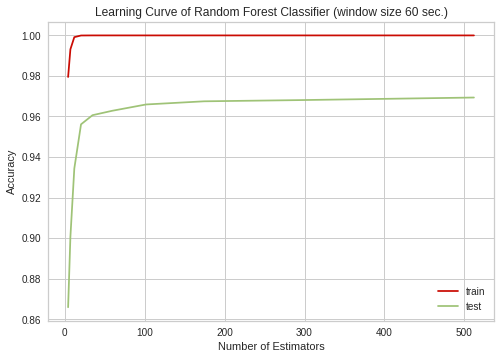

In [19]:
def plot_learning_curve_from_errors(train_errors, test_errors, n_estimator_options, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_title(f"Learning Curve of Random Forest Classifier (window size {WINDOW_SIZE} sec.)")
    ax.plot(n_estimator_options, train_errors, '-r', label="train")
    ax.plot(n_estimator_options, test_errors, '-g', label="test")
    ax.set_xlabel("Number of Estimators")
    ax.set_ylabel("Accuracy")
    _ = ax.legend()


plot_learning_curve_from_errors(train_errors=train_errors, test_errors=test_errors,
                                n_estimator_options=n_estimator_options)

### plot learning curve from cv results for all models


In [88]:
cv_results["params"] = cv_results["params"].apply(lambda x: json.dumps(x))
cv_results


,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__max_features,param_classifier__n_estimators,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0,1,1.889948,0.059151,0.056839,0.032940,entropy,70,sqrt,1,...,0.859901,0.854204,0.858720,0.866949,0.865327,0.858245,0.863626,0.858997,0.861246,0.003693
1,0,1,1.910338,0.044870,0.059813,0.018304,entropy,30,sqrt,1,...,0.857883,0.856301,0.866355,0.856306,0.857335,0.863507,0.863032,0.859986,0.859596,0.003575
2,0,1,1.869183,0.059332,0.058031,0.026924,entropy,24,sqrt,1,...,0.843640,0.846409,0.847405,0.850965,0.845901,0.847919,0.847484,0.859115,0.848055,0.004332
3,0,1,1.868916,0.097252,0.059173,0.022890,entropy,56,sqrt,1,...,0.862077,0.860851,0.857731,0.859946,0.865406,0.863032,0.858997,0.868887,0.861697,0.003165
4,0,1,1.911403,0.059779,0.061906,0.023934,entropy,73,sqrt,1,...,0.859624,0.862868,0.862834,0.859313,0.859828,0.859907,0.862201,0.860817,0.861451,0.001660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4499,6,729,485.018025,3.983984,0.973069,0.127142,entropy,17,sqrt,729,...,0.984451,0.983106,0.985006,0.981920,0.983977,0.982671,0.982632,0.984808,0.983474,0.001005
4500,6,729,484.073645,3.784699,0.981158,0.144075,entropy,17,sqrt,729,...,0.982987,0.983581,0.984412,0.983027,0.982038,0.983937,0.982632,0.984491,0.983510,0.000899
4501,6,729,461.465038,65.996746,0.888021,0.213941,entropy,18,sqrt,729,...,0.993630,0.993274,0.993749,0.992958,0.992958,0.993314,0.993433,0.994263,0.993464,0.000394
4502,7,2187,1447.962617,10.710534,3.763025,1.068874,entropy,17,sqrt,2187,...,0.984174,0.982829,0.983819,0.983383,0.983423,0.983304,0.983858,0.985362,0.983985,0.000771


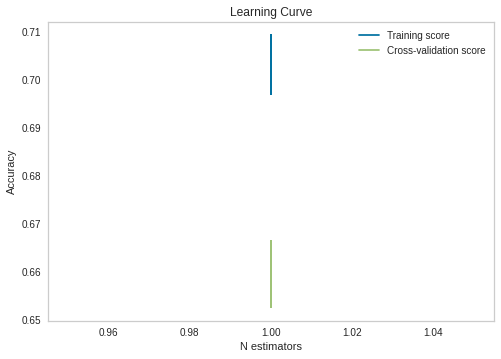

In [87]:
fig, ax = plt.subplots()
i = 0
for param, group in cv_results.groupby("params"):
    # group = group.drop_duplicates(subset=("iter"))
    if len(group) < 10:
        continue
    plot_learning_curve(search_cv_results=group, ax=ax, show_legend=True)
    break
    # i += 1
    # if i == 100:
    #     break
plt.show()

In [92]:
group["param_classifier__n_estimators"].unique()

array([1], dtype=object)

In [ ]:
_ = plt.plot(n_estimator_options, test_errors, '-r')
